# 생체인증보안 1871085 얼굴 1차 코드

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4927892095342710084
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10768720896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6039014614259174462
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1"
]


In [216]:
# 라이브러리 import
import PIL.Image as pilimg
import numpy as np
import glob
import matplotlib.pyplot as plt
import re

In [217]:
# 이미지 목록
images = glob.glob('./02_face_training/*.BMP')
len(images)

1050

In [218]:
r = re.compile('\d+')

img = [] # 이미지
label = [] # 라벨

for fname in images:
    l = r.findall(fname)[1]
    label.append(l)
    im = pilimg.open(fname)
    pix = np.array(im)/255. # Normalize
    img.append(pix)

In [219]:
X = np.array(img)
X = X.reshape(X.shape[0],56,46,1)
X.shape # img shape

(1050, 56, 46, 1)

In [220]:
y = np.array(label, dtype='int32')
y # label

array([132, 289, 283, ..., 144, 270, 260], dtype=int32)

In [221]:
X[0].shape

(56, 46, 1)

(56, 46, 1)
132


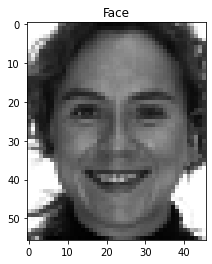

In [222]:
# 얼굴 이미지
plt.title('Face')
plt.imshow(X[0].reshape(56,46), cmap='gray')
print(X[0].shape)
print(y[0])

In [223]:
X.shape

(1050, 56, 46, 1)

## Data Augmentation

In [224]:
# !pip install imgaug

In [225]:
from imgaug import augmenters as iaa

In [226]:
seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.1
    iaa.GaussianBlur(sigma=(0, 0.1)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.01, 0.01), "y": (-0.01, 0.01)},
        # rotate by -5 to +5 degrees
        rotate=(-5, 5),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=0
    )
], random_order=True)

def aug_data(X_data, y_data):
    augmentated_data = [] # 생성한 이미지
    augmentated_label = [] # 생성한 이미지의 라벨
    for i in range(len(X)):
        augs = [X[i]] * 9 # 이미지당 9개 추가 생성
        augs = seq.augment_images(augs)
        for aug in augs:
            augmentated_data.append(aug)
            augmentated_label.append(y_data[i])
    
    return augmentated_data, augmentated_label

In [227]:
x_d, y_d = aug_data(X, y) # 이미지 생성

In [228]:
print(len(x_d), len(y_d))

9450 9450


(56, 46, 1)
132


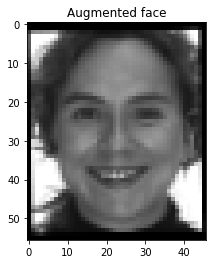

In [230]:
# 생성한 얼굴 이미지
plt.title('Augmented face')
plt.imshow(x_d[1].reshape(56,46), cmap='gray')
print(x_d[1].shape)
print(y_d[1])

In [231]:
# 생성한 이미지
x_d = np.array(x_d)
y_d = np.array(y_d)
print(x_d.shape)
print(y_d.shape)

(9450, 56, 46, 1)
(9450,)


In [232]:
# 기존 이미지
print(X.shape)
print(y.shape)

(1050, 56, 46, 1)
(1050,)


In [233]:
# 기존 이미지, 생성 이미지 합치기
X_data = np.concatenate([X, x_d], axis=0)
y_data = np.concatenate([y, y_d], axis=0)
print(X_data.shape)
print(y_data.shape)

(10500, 56, 46, 1)
(10500,)


# Data split

In [189]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.1, shuffle=True, stratify=y_data, random_state=101)

In [190]:
X_train=X_train.astype('float32')
y_train=y_train.astype('int32')
X_test=X_test.astype('float32')
y_test=y_test.astype('int32')

In [191]:
X_train = X_train.reshape(X_train.shape[0],56,46,1)
X_test = X_test.reshape(X_test.shape[0],56,46,1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9450, 56, 46, 1) (9450,) (1050, 56, 46, 1) (1050,)


In [192]:
# Input shape
X_train[0].shape

(56, 46, 1)

In [193]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=351)
y_test = to_categorical(y_test, num_classes=351)

# Model

In [194]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Dropout
from sklearn.model_selection import StratifiedKFold

In [29]:
# !pip install keras_vggface
# !pip install keras_applications

In [195]:
def build_model():
    learning_rate = 0.00001
    width = 56
    height = 46
    METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy')
    ]
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(2,2), padding='same', activation='relu', input_shape=(width,height,1)))
    model.add(Conv2D(filters=64, kernel_size=(2,2), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=32, kernel_size=(2,2), padding='same', activation='relu')) 
    model.add(Conv2D(filters=32, kernel_size=(2,2), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(0.1))
    model.add(Dense(351, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 56, 46, 64)        320       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 56, 46, 64)        16448     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 28, 23, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 28, 23, 32)        8224      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 28, 23, 32)        4128      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 11, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4928)            

In [197]:
# Cross validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)
all_history = [] # 결과 저장

def score_model(model, cv=None):
    if cv is None:
        cv = KFold(n_splits=4, random_state=42, shuffle=True)
        
    i=0
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        i=i+1
        print('Fold #',i)
        # Get the training data
        X_train_fold, y_train_fold = X_train[train_fold_index], y_train[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train[val_fold_index], y_train[val_fold_index]
        
        x,y,z,w = X_train_fold.shape

        print(X_val_fold.shape)
        print(y_val_fold.shape)
        
        # Fit the model
        model_obj = model.fit(X_train_fold, y_train_fold,
                              epochs=10,
                              validation_data=(X_val_fold, y_val_fold), 
                              verbose=1)
        all_history.append(model_obj.history)

# Example of the model in action
score_model(model, cv=kf)
model.save('./facemodelv7.h5')

Fold # 1
(2363, 56, 46, 1)
(2363, 351)
Epoch 1/10
222/222 [==============================] - 2s 8ms/step - loss: 2.5624 - accuracy: 0.3522 - val_loss: 1.1537 - val_accuracy: 0.6758
Epoch 2/10
222/222 [==============================] - 2s 8ms/step - loss: 0.8550 - accuracy: 0.7610 - val_loss: 0.4537 - val_accuracy: 0.8853
Epoch 3/10
222/222 [==============================] - 2s 8ms/step - loss: 0.4747 - accuracy: 0.8802 - val_loss: 0.3109 - val_accuracy: 0.9348
Epoch 4/10
222/222 [==============================] - 2s 8ms/step - loss: 0.3352 - accuracy: 0.9266 - val_loss: 0.3211 - val_accuracy: 0.9353
Epoch 5/10
222/222 [==============================] - 2s 8ms/step - loss: 0.2873 - accuracy: 0.9443 - val_loss: 0.2023 - val_accuracy: 0.9670
Epoch 6/10
222/222 [==============================] - 2s 8ms/step - loss: 0.2488 - accuracy: 0.9527 - val_loss: 0.1741 - val_accuracy: 0.9784
Epoch 7/10
222/222 [==============================] - 2s 7ms/step - loss: 0.2091 - accuracy: 0.9651 - val_los

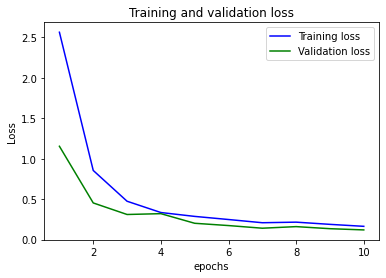

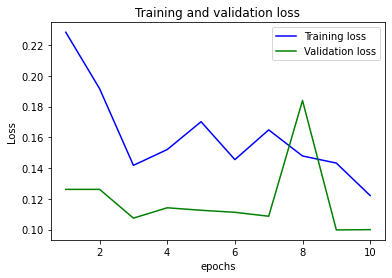

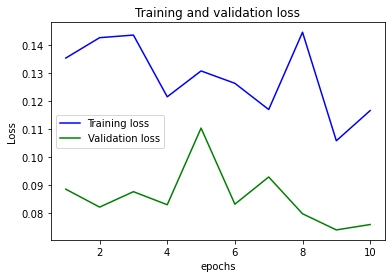

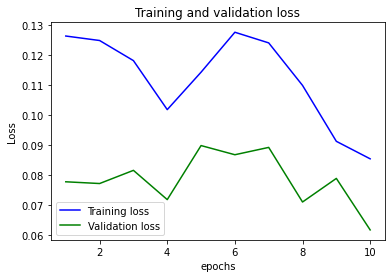

In [198]:
# Loss
for i in range(4):
    loss = all_history[i].get('loss') # train
    val_loss = all_history[i].get('val_loss') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training loss')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_loss, 'g', label='Validation loss') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

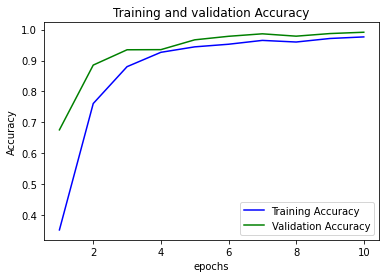

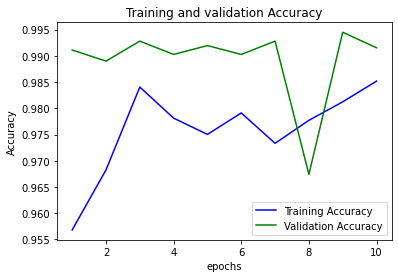

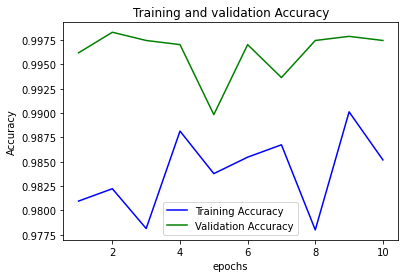

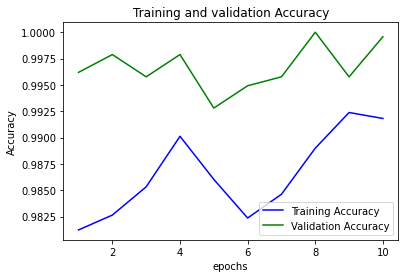

In [199]:
# Accuracy
for i in range(4):
    loss = all_history[i].get('accuracy') # train
    val_loss = all_history[i].get('val_accuracy') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training Accuracy')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_loss, 'g', label='Validation Accuracy') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Training and validation Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [200]:
preds = np.argmax(model.predict(X_test), axis=1)
preds

array([170, 225, 114, ..., 178,  34, 226])

In [201]:
y_test_origin = np.argmax(y_test, axis=1)
y_test_origin

array([170, 225, 114, ..., 178,  34, 226])

(56, 46)
예측:  170
실제:  170


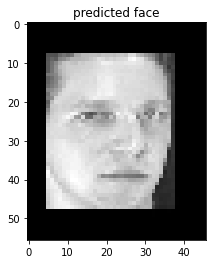

In [202]:
# 예측결과
plt.title('predicted face')
this_img = X_test[0].reshape(56,46)
plt.imshow(this_img, cmap='gray')
print(this_img.shape)
print('예측: ', preds[0])
print('실제: ', y_test_origin[0])
#X_test[0]

# Result

In [203]:
from sklearn.metrics import mean_squared_error
# rmse
rmse = np.sqrt(mean_squared_error(y_test_origin, preds)) 
print("RMSE: %f" % (rmse))

RMSE: 0.617213


In [204]:
from sklearn.metrics import multilabel_confusion_matrix
cm = multilabel_confusion_matrix(y_test_origin, preds)

In [205]:
cm

array([[[1047,    0],
        [   0,    3]],

       [[1047,    0],
        [   0,    3]],

       [[1047,    0],
        [   0,    3]],

       ...,

       [[1047,    0],
        [   0,    3]],

       [[1047,    0],
        [   0,    3]],

       [[1047,    0],
        [   0,    3]]])

In [206]:
# 평가지표 계산
def confusion(cm):
    return cm[0][0], cm[0][1], cm[1][0], cm[1][1]

def accuracy(cm):
    TP, FN, FP, TN = confusion(cm)
    return (TP+TN)/(TP+TN+FP+FN)

def precision(cm):
    TP, FN, FP, TN = confusion(cm)
    return TP/(TP+FP)

def recall(cm):
    TP, FN, FP, TN = confusion(cm)
    return TP/(TP+FN)

def F1(cm):
    return 2*precision(cm)*recall(cm)/(precision(cm)+recall(cm))

In [207]:
# Macro Average 평가지표 계산
accuracy_avg = 0
precision_avg = 0
recall_avg = 0
F1_avg = 0

for i in range(len(cm)):
    accuracy_avg += accuracy(cm[i])
    precision_avg += precision(cm[i])
    recall_avg += recall(cm[i])
    F1_avg += F1(cm[i])

accuracy_avg /= len(cm)
precision_avg /= len(cm)
recall_avg /= len(cm)
F1_avg /= len(cm)

print('accuracy: ', accuracy_avg)
print('precision: ', precision_avg)
print('recall: ', recall_avg)
print('F1: ', F1_avg)

accuracy:  0.9999945578231292
precision:  0.9999972737186477
recall:  0.9999972711147497
F1:  0.9999972711141274


## Test

In [208]:
images = glob.glob('./02_face_test/*.bmp')
len(images)

700

In [209]:
r = re.compile('\d+')

img = [] # 이미지
img_num = [] # 이미지 번호

for fname in images:
    num = r.findall(fname)[1]
    img_num.append(num)
    im = pilimg.open(fname)
    pix = np.array(im)/255. # Normalize
    img.append(pix)

(56, 46)
529


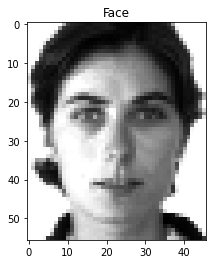

In [210]:
# 얼굴 이미지
plt.title('Face')
plt.imshow(img[0].reshape(56,46), cmap='gray')
print(img[0].shape)
print(img_num[0])

In [211]:
X = np.array(img)
X = X.astype('float32')
X = X.reshape(X.shape[0],56,46,1)

In [212]:
preds = np.argmax(model.predict(X), axis=1)
preds

array([130, 348, 232,  76, 168, 274, 241, 309, 329, 150, 274, 158,  84,
       326, 107,   2, 308, 306, 211, 285, 163, 350,  40,  32, 329, 290,
       120, 186, 270, 241, 261,  56, 238,  18, 282, 152, 325,  54, 117,
       309, 177, 271, 257, 314, 321, 282,  65,  76, 167,  65, 295, 185,
        67, 206, 177,  79, 302, 302,  67, 202, 234, 224, 126, 229,  53,
       349, 208, 289, 324, 184, 310, 271, 233, 271, 265, 340, 276, 287,
       165,  54,  32, 277, 268, 217, 323, 177, 186, 164, 333,  30,  76,
       306,  38,  76, 192,  96, 177, 150, 274, 197, 339, 117, 317, 334,
       232,  57, 263, 302, 116, 263, 309, 282, 101, 234, 109, 214, 258,
       288, 217,  64, 260, 183, 345,  60, 218, 168, 260, 102, 177, 254,
       158, 149, 246,   3, 269, 117, 333, 345, 334, 267, 274, 207, 180,
       306,  51,  57, 179, 111, 216, 191, 236, 192, 194, 214, 181, 297,
       254, 117, 345, 246, 274, 229, 184,   2, 322, 280, 131, 347, 293,
       193, 284, 345, 287, 340, 282, 201, 233, 312, 275, 257, 17

In [213]:
import pandas as pd
res_df = pd.DataFrame(img_num, columns=['Image'], dtype='int32')
res_df['Answer'] = pd.Series(preds, dtype='int32')
res_df.sort_values(by=['Image'], axis=0, inplace=True)
res_df

,Image,Answer
15,1,2
28,2,270
359,3,188
248,4,214
290,5,303
...,...,...
199,696,93
402,697,182
481,698,201
534,699,15


In [214]:
res_df['Answer'].value_counts()

57     9
282    9
227    9
274    9
233    8
      ..
315    1
92     1
212    1
84     1
1      1
Name: Answer, Length: 275, dtype: int64

In [215]:
res_df.to_csv('./1871085_얼굴_1차_답안v7.csv', index=False)